In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv("/kaggle/input/sentiment-analysis-dataset/all_kindle_review.csv")

In [4]:
data.head()

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [5]:
data=data[['reviewText','rating']]
data.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4


In [6]:
data=data[['reviewText','rating']]
data.tail()

,reviewText,rating
11995,Valentine cupid is a vampire- Jena and Ian ano...,4
11996,I have read all seven books in this series. Ap...,5
11997,This book really just wasn't my cuppa. The si...,3
11998,"tried to use it to charge my kindle, it didn't...",1
11999,Taking Instruction is a look into the often hi...,3


In [7]:
data.shape

(12000, 2)

In [8]:
data.isnull().sum()

reviewText    0
rating        0
dtype: int64

In [9]:
data['rating'].unique()

array([3, 5, 4, 2, 1])

In [10]:
data['rating'].value_counts()


rating
5    3000
4    3000
3    2000
2    2000
1    2000
Name: count, dtype: int64

In [11]:
print(data['reviewText'].dtype)

object


In [12]:
## data preprocessing and cleaning
data['rating']=data['rating'].apply(lambda x:0 if x<3 else 1)

In [13]:
data['rating']

0        1
1        1
2        1
3        1
4        1
        ..
11995    1
11996    1
11997    1
11998    0
11999    1
Name: rating, Length: 12000, dtype: int64

In [14]:
data['rating'].unique()

array([1, 0])

In [15]:
data['rating'].value_counts()

rating
1    8000
0    4000
Name: count, dtype: int64

In [16]:
from sklearn.utils import resample

majority = data[data['rating'] == 1]
minority = data[data['rating'] == 0]

majority_downsampled = resample(majority,
                                replace=False,     # no replacement
                                n_samples=len(minority), # match minority
                                random_state=42)

# Combine back
balanced_data = pd.concat([majority_downsampled, minority])

print(balanced_data['rating'].value_counts())

rating
1    4000
0    4000
Name: count, dtype: int64


In [17]:
## lower all the cases
data['reviewText']=data['reviewText'].str.lower()

In [18]:
data['reviewText']

0        jace rankin may be short, but he's nothing to ...
1        great short read.  i didn't want to put it dow...
2        i'll start by saying this is the first of four...
3        aggie is angela lansbury who carries pocketboo...
4        i did not expect this type of book to be in li...
                               ...                        
11995    valentine cupid is a vampire- jena and ian ano...
11996    i have read all seven books in this series. ap...
11997    this book really just wasn't my cuppa.  the si...
11998    tried to use it to charge my kindle, it didn't...
11999    taking instruction is a look into the often hi...
Name: reviewText, Length: 12000, dtype: object

In [19]:
import re
import numpy as np
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
stop_words.discard('not')
stop_words.discard('no')
stop_words.discard('nor')
stop_words.discard('never')

def clean_text(text):
    text = str(text).lower()
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub(r'(http|https|ftp|ssh)://\S+', '', text)
    text = re.sub('[^a-z ]', '', text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(words)

data['reviewText'] = data['reviewText'].apply(clean_text)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    data['reviewText'],
    data['rating'],
    test_size=0.2,
    random_state=42
)


In [22]:
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

bow_model = MultinomialNB()
bow_model.fit(X_train_bow, y_train)

y_pred_bow = bow_model.predict(X_test_bow)
print("BoW Accuracy:", accuracy_score(y_test, y_pred_bow))


BoW Accuracy: 0.84125


In [23]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

tfidf_model = MultinomialNB()
tfidf_model.fit(X_train_tfidf, y_train)

y_pred_tfidf = tfidf_model.predict(X_test_tfidf)
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))


TF-IDF Accuracy: 0.6941666666666667


In [24]:
X_train_tokens = [word_tokenize(text) for text in X_train]
X_test_tokens = [word_tokenize(text) for text in X_test]

w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)


In [25]:
def document_vector(tokens, model):
    tokens = [w for w in tokens if w in model.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[tokens], axis=0)

X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in X_train_tokens])
X_test_w2v = np.array([document_vector(doc, w2v_model) for doc in X_test_tokens])


In [26]:
lr_w2v = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)
lr_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = lr_w2v.predict(X_test_w2v)
print("Word2Vec Accuracy:", accuracy_score(y_test, y_pred_w2v))


Word2Vec Accuracy: 0.7679166666666667


In [27]:
def predict_sentiment(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    vec = document_vector(tokens, w2v_model).reshape(1, -1)
    return lr_w2v.predict(vec)[0]

print(predict_sentiment("i love this product"))     # Positive
print(predict_sentiment("i hate this product"))     # Negative
print(predict_sentiment("service quality is poor")) # Negative


1
0
0


In [28]:
import joblib

joblib.dump(lr_w2v, "w2v_lr_model.pkl")
w2v_model.save("w2v_model.model")


In [29]:
print("Word2Vec training set shape:", X_train_w2v.shape)
print("Word2Vec test set shape:", X_test_w2v.shape)


Word2Vec training set shape: (9600, 100)
Word2Vec test set shape: (2400, 100)


In [30]:
from sklearn.metrics import accuracy_score

w2v_accuracy = accuracy_score(y_test, y_pred_w2v)
print("Word2Vec accuracy:", w2v_accuracy)


Word2Vec accuracy: 0.7679166666666667


In [31]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred_w2v))


Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.77      0.69       803
           1       0.87      0.77      0.81      1597

    accuracy                           0.77      2400
   macro avg       0.75      0.77      0.75      2400
weighted avg       0.79      0.77      0.77      2400



In [32]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_w2v, average=None
)

summary_table = pd.DataFrame({
    "Class": ["Negative (0)", "Positive (1)"],
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

print("\nWord2Vec Model Performance Summary:\n")
print(summary_table)



Word2Vec Model Performance Summary:

          Class  Precision    Recall  F1-Score  Support
0  Negative (0)   0.624242  0.769614  0.689347      803
1  Positive (1)   0.868794  0.767063  0.814766     1597


In [33]:
overall_table = pd.DataFrame({
    "Metric": ["Accuracy", "Macro F1", "Weighted F1"],
    "Value": [
        w2v_accuracy,
        f1.mean(),
        (f1 * support).sum() / support.sum()
    ]
})

print("\nOverall Metrics:\n")
print(overall_table)



Overall Metrics:

        Metric     Value
0     Accuracy  0.767917
1     Macro F1  0.752057
2  Weighted F1  0.772803


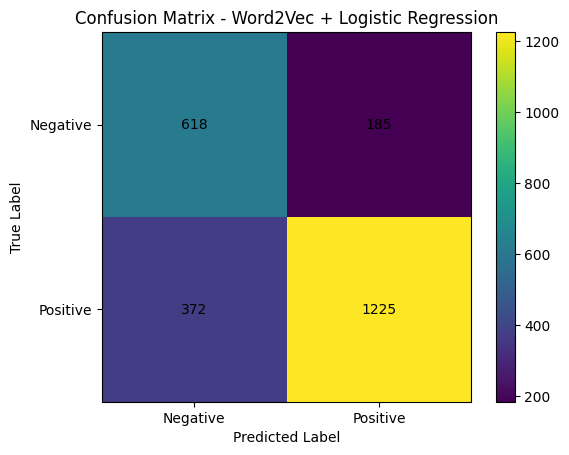

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_w2v)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - Word2Vec + Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


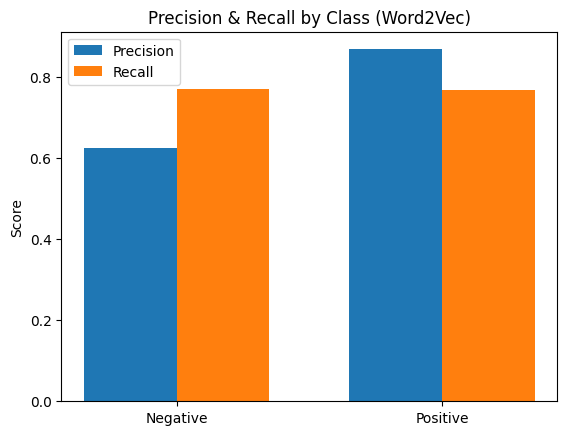

In [35]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_w2v, average=None
)

labels = ["Negative", "Positive"]
x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, precision, width, label="Precision")
plt.bar(x + width/2, recall, width, label="Recall")

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Precision & Recall by Class (Word2Vec)")
plt.legend()
plt.show()


In [36]:
bow_acc = accuracy_score(y_test, y_pred_bow)
tfidf_acc = accuracy_score(y_test, y_pred_tfidf)
w2v_acc = accuracy_score(y_test, y_pred_w2v)


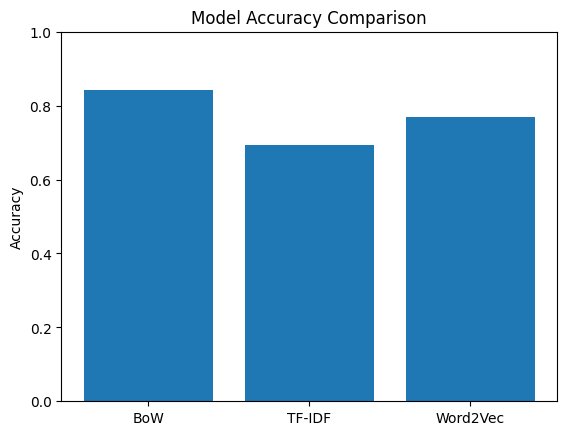

In [37]:
models = ["BoW", "TF-IDF", "Word2Vec"]
accuracies = [bow_acc, tfidf_acc, w2v_acc]

plt.figure()
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()
